# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.646543,False,0.033826
1,1.527600,False,-0.239594
2,1.097988,True,5.971463
3,-0.797248,True,4.928882
4,-0.115689,False,-0.093215
...,...,...,...
995,1.436270,False,1.102132
996,1.550079,True,7.405873
997,3.277287,False,2.544209
998,1.352804,False,0.556050


<Axes: xlabel='v0'>

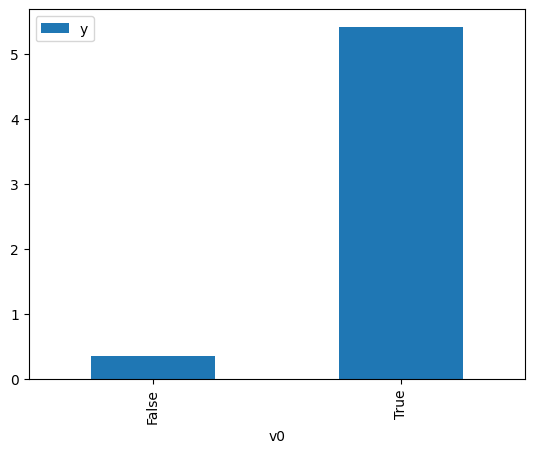

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

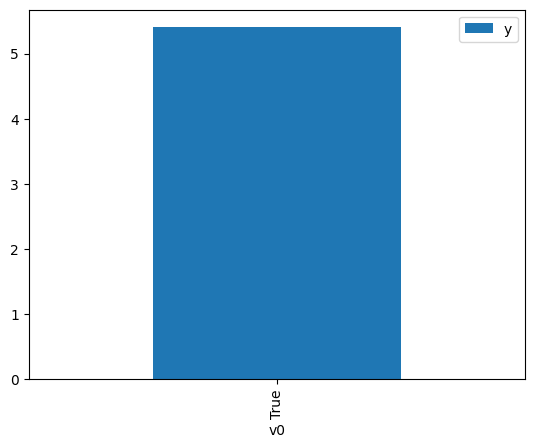

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.056421,False,1.805122,0.299215,3.342084
1,0.309448,False,-0.135718,0.443201,2.256313
2,1.078169,False,-0.385077,0.295426,3.384944
3,-2.010174,False,0.574037,0.846320,1.181586
4,2.316295,False,1.488426,0.129930,7.696476
...,...,...,...,...,...
995,-0.135581,False,0.061334,0.535665,1.866837
996,2.016184,False,0.361125,0.160929,6.213936
997,1.784319,False,1.249384,0.188774,5.297337
998,0.290405,False,-1.613832,0.447123,2.236521


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.840504,True,7.476787,0.661727,1.511197
1,-0.004606,True,6.097482,0.491578,2.034265
2,-0.526528,True,4.514917,0.384878,2.598224
3,0.913513,True,5.425661,0.675217,1.481005
4,-0.157850,True,5.136871,0.459719,2.175241
...,...,...,...,...,...
995,0.931825,True,5.382999,0.678557,1.473716
996,0.768037,True,5.055411,0.648072,1.543039
997,2.620760,True,6.858828,0.896178,1.115850
998,1.765639,True,5.569043,0.808829,1.236355


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9887.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):                        0.00
Time:                        14:49:48   Log-Likelihood:                         -1415.0
No. Observations:                1000   AIC:                                      2834.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6855      0.033     20.957      0.000       0.621       0.750
x2             5.0243      0.050     99.602      0.000       4.925       5.123
==============================================================================
Omnibus:                        2.434   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.296   Jarque-Bera (JB):                2.208
Skew:                           0.034   Prob(JB):                        0.332
Kurtosis:                       2.780   Cond. No.                         2.28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""